# Exploring Willy Wonka

### Introduction

### Reading prompt

* Summary - The data does not reveal much difference between our power users (who account for 80% of )and the normal users.  
* More research needed on the power users -- what keeps them returning?  What other similar competitors do they shop at, and can we offer more similar products.
* There is a small difference in product preference, with users spending on healthy food like energy shots, and protein..whereas non-power users spend more on granola bars.
* Odd that the marketing emphasizes things like chocolate whereas users appear to be more health conscious.
* Top loyalty program is silver followed by none -- so appears that gold and bronze are underperforming.


In [1]:
from lib import load_data
import pandas as pd

engine, df = load_data()
df[:1]

,level_0,index,order_id,user_id,list_sku,list_sku_category,list_sku_flavor,list_lineitem_id,order_date,order_value,...,order_coupon_code,order_referrer,order_ad_shown,order_store_city,order_store_id,order_day_part,order_is_freeshipping,user_loyalty_program,user_age,user_gender
0,0,0,TXN-52889719,USER-16961214,SKU-3002,Energy Bar,Peanut Butter,ITEM-2009089674,2021-05-04,49.325488,...,express5,Microsoft,week40_10,Dallas,Dallas-3,evening,1,bronze,49,F


### Percentile Spend by user

Write a sql query to calculate a running total of the total spend per user.  For example, maybe the top spending user is responsible for 1% of of all sales.  And by the second user we get to 1.5% spend of all sales, as that second user is responsible for .5% of all sales.

In [17]:
query = """with  user_spend as (
    select user_id, sum(order_value) as total_order_value 
    from orders 
    group by user_id
    order by total_order_value desc),
    user_running_total as (
    select user_id, total_order_value,
    sum(total_order_value) over (order by total_order_value desc) as running_total,
    sum(total_order_value) over () as total_spend
    from user_spend)
    select user_id, total_order_value, running_total/total_spend as percentage_spend from user_running_total;
"""
user_percentage_spend = pd.read_sql(query, engine)

* Core users

In [24]:
core_users = user_percentage_spend[user_percentage_spend['percentage_spend'] > .50]

core_users.shape

(85073, 3)

* Power users

In [26]:
power_users = user_percentage_spend[user_percentage_spend['percentage_spend'] < .50]
power_users.shape

(17777, 3)

In [28]:
power_users.shape[0]/user_percentage_spend.shape[0]

0.1728439474963539

In [87]:
# power_users.describe()

### Now select the power users

In [30]:
query = """select * from orders"""
orders_df = pd.read_sql(query, engine)

In [32]:
orders_df.index = orders_df.user_id

In [34]:
power_user_orders_df = orders_df.loc[power_users.user_id]

In [46]:
pd.read_sql('select * from power_users limit 3', engine)

,user_id,order_id,list_sku,list_sku_category,list_sku_flavor,list_lineitem_id,order_date,order_value,order_item_count,order_single_item,...,order_store_city,order_store_id,order_day_part,order_is_freeshipping,user_loyalty_program,user_age,user_gender,month,week,dow


In [92]:
core_user_orders_df = orders_df.loc[core_users.user_id]

In [93]:
core_user_orders_df.index = core_user_orders_df['index']
core_user_orders_df = core_user_orders_df.drop(columns = ['index'])
core_user_orders_df.to_sql('core_user_orders', engine)

613

In [94]:
power_user_orders_df = orders_df.loc[power_users.user_id]
power_user_orders_df = power_user_orders_df.drop(columns = ['index'])
power_user_orders_df.index = list(range(0, 46414))
power_user_orders_df.to_sql('power_user_orders', engine, if_exists='replace')

414

In [120]:
query = """select user_id, sum(order_value) as order_value, max(user_age) as user_age, max(user_gender) user_gender, max(order_store_city) order_store_city, max(order_store_id) order_store_id, max(user_loyalty_program) user_loyalty_program from power_user_orders group by user_id"""
# 
power_users = pd.read_sql(query, engine)

power_users.to_sql('power_users', engine, if_exists = 'replace')

777

In [119]:
query = """select user_id, sum(order_value) as order_value, max(user_age) as user_age, max(user_gender) user_gender, max(order_store_city) order_store_city, max(order_store_id) order_store_id, max(user_loyalty_program) user_loyalty_program from core_user_orders group by user_id
"""
# 
core_users = pd.read_sql(query, engine)

core_users.to_sql('core_users', engine, if_exists = 'replace')

73

### Now compare power users to core users

user_age


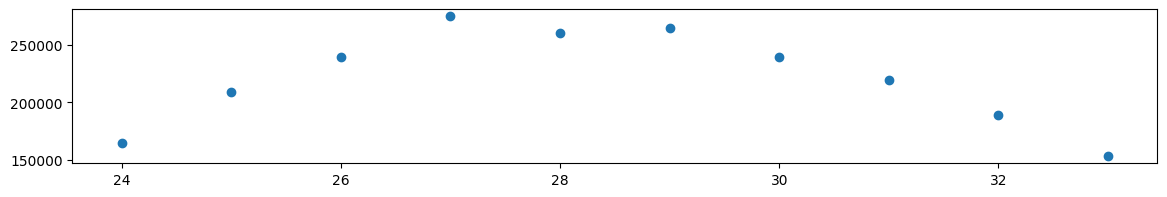

user_gender


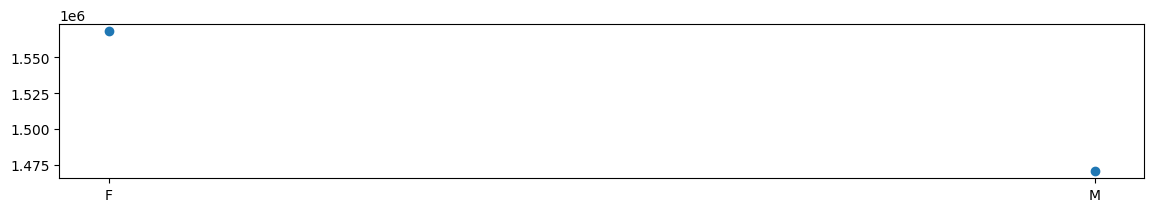

user_loyalty_program


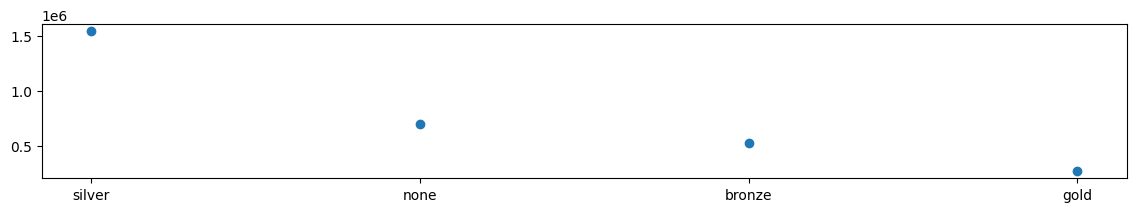

In [121]:
from lib import build_grouped_bys, group_and_print, timing_cols, product_cols, marketing_cols, location_cols

user_cols = ['user_age', 'user_gender', 'user_loyalty_program']

group_and_print('power_users', user_cols, engine)

list_sku


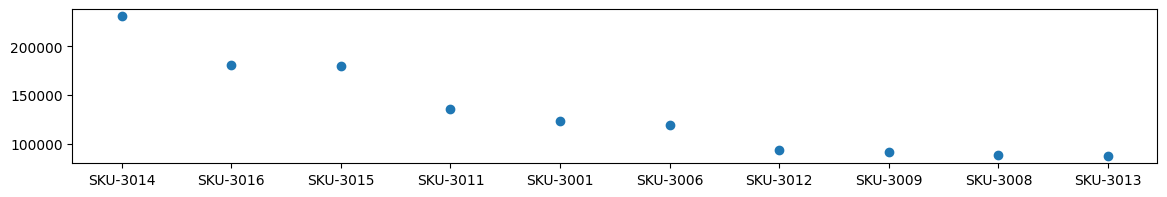

list_sku_category


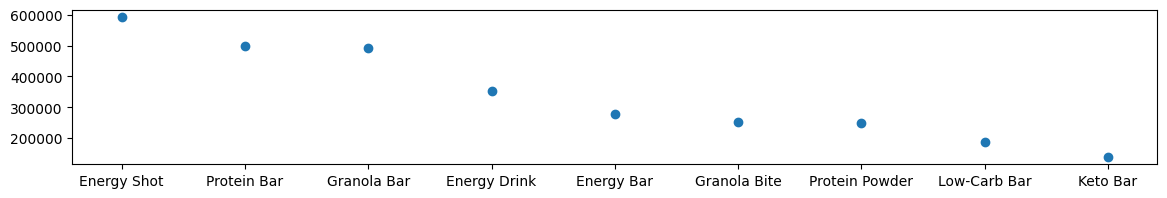

list_sku_flavor


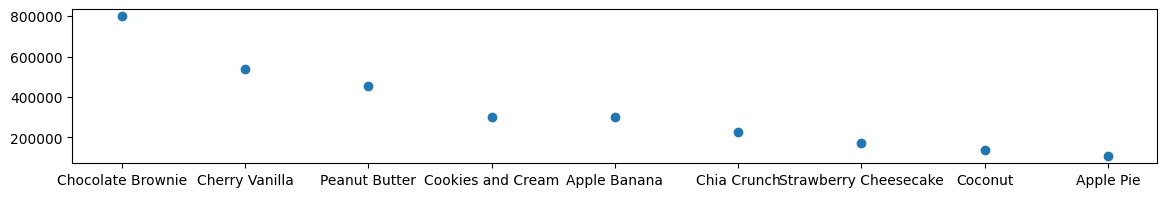

In [116]:
group_and_print('power_user_orders', product_cols, engine)

order_channel


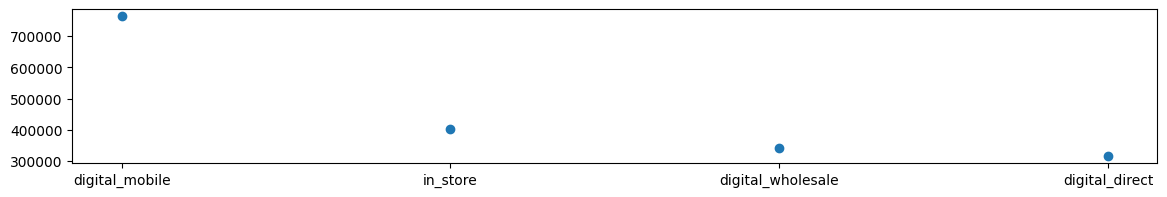

order_referrer


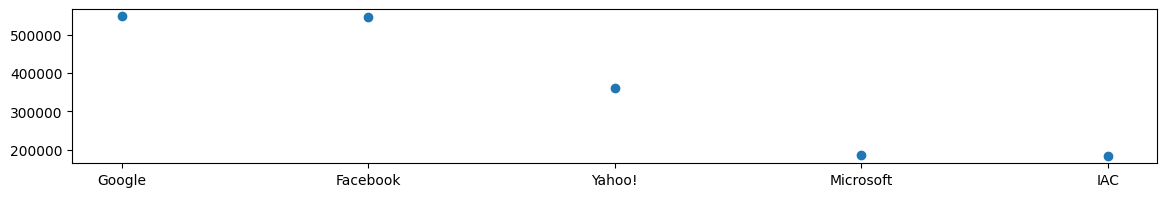

order_ad_shown


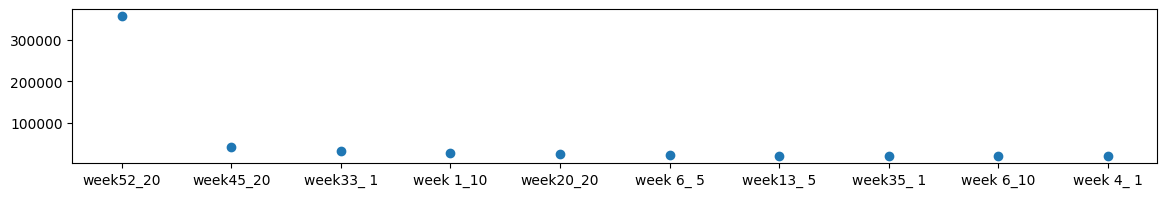

order_is_freeshipping


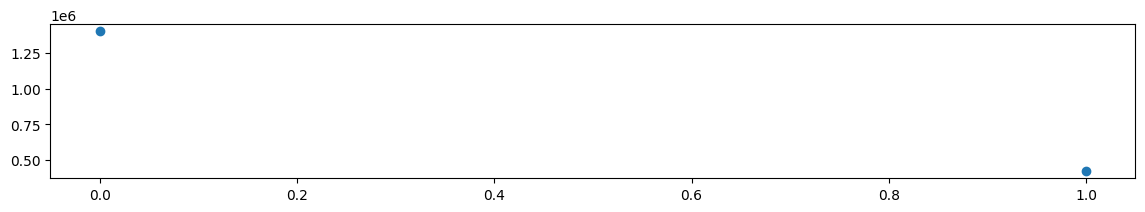

order_coupon_code


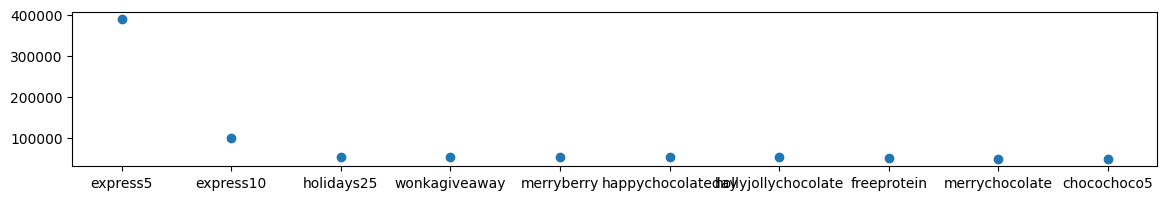

user_loyalty_program


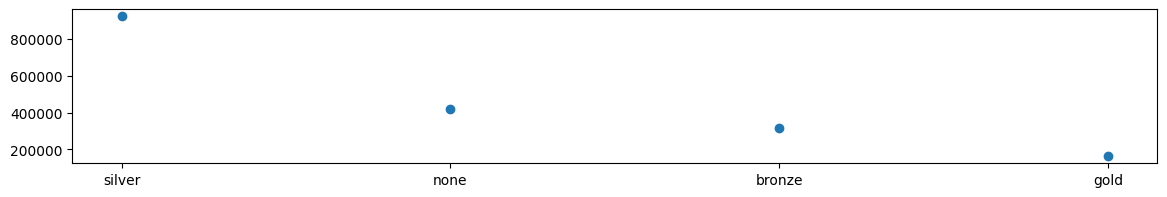

In [46]:
group_and_print(power_user_orders_df, marketing_cols)